# Analyzer

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib as mpl 

mpl.rcParams['figure.dpi']= 200
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

from skmisc.loess import loess

from rpy2.robjects import pandas2ri
pandas2ri.activate()

%reload_ext rpy2.ipython

## Intitiate R environment and packages

In [2]:
%%R

library('lme4')
library('margins')
library("performance")
library('tidyverse')
library('broom.mixed')

getICCs <- function(m, type = 'poisson'){
  var_s <- as.numeric(getME(m, "theta")[1]^2) # seller level variance
  var_w <- as.numeric(getME(m, "theta")[2]^2) # week level variance
  
  if(type == 'poisson'){
    lambda = .139
    alpha <- log(1 + 1/lambda)
  }
  if(type == 'binomial'){
    alpha <- (pi^2) / 3
  }
  
  icc <- list(
    s = (var_s)/ (var_s + var_w + alpha),
    w = (var_w)/ (var_s + var_w + alpha),
    t = (var_s + var_w)/ (var_s + var_w + alpha),
    a = (alpha)/ (var_s + var_w + alpha)
  )
  
  return(icc)
}

sessionInfo()

R[write to console]: Loading required package: Matrix

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()

R[write to console]: Registered S3 method overwritten by 'broom.mixed':
  method      from 
  tidy.gamlss broom



R version 4.0.3 (2020-10-10)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] broom.mixed_0.2.6 forcats_0.5.0     stringr_1.4.0     dplyr_1.0.2      
 [5] purrr_0.3.4       readr_1.4.0       tidyr_1.1.2       tibble_3.0.4     
 [9] ggplot2_3.3.2     tidyverse_1.3.0   performance_0.5.1 margins_0.3.23   
[13] lme4_1.1-25       Matrix_1.2-18    

loaded via a namespace (and not attached):
 [1] statmod_1.4.35    TMB_1.7.19        tidyselect_1.1.0  reshape2_1.4.4   
 [5] splines_4.0.3     haven_2.3.1       lattice_0.20-41   colorspace_1.4-1 
 [9] vctrs_0.3.4       generics_0.0.2    blob_1.2.1        rlang_0.4.8      
[13] nloptr_1.2.2.2    pillar_1.4.6      withr_2.3.0       glue_1.4.

## Import Data

In [3]:
MAINDIR = os.getcwd().rsplit('/', 1)[0]
PATH = os.path.join(MAINDIR, 'data/analysis')

df = pd.read_pickle(os.path.join(PATH, 'vendor_week.pickle'))
df = df.merge(df.groupby('vendor')['me_min'].min().rename('me'), on = 'vendor')
df = df.rename(columns= {
    'international_shipment_count_w': 'int_shipment_count_w', 
    'international_shipment': 'int_shipment'})

### Transform variables for analysis

In [4]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

# normalize variables
skewed_variables = [
    'neg_count_min', 'pos_count_min', 'neg_count_w', 
    'neg_count_w_shift', 'pos_count_w', 'pos_count_w_shift', 'sales_volume_w', 
    'item_count_w', 'int_shipment_count_w']
bc_vars = pd.DataFrame(
    pt.fit_transform(df[skewed_variables]),
    columns = ['bc_' + var for var in skewed_variables])

c_vars = df[skewed_variables].add_prefix('c_')

dummy_vars = df.assign(
        items   = pd.qcut(df['item_count'], 3,  labels=["low", "medium", "high"]),
        items_w = pd.qcut(df['item_count_w'], 3,  labels=["low", "medium", "high"]),
        sales   = pd.qcut(df['cum_count'], 2,  labels=["low", "high"]),
        sales_w = pd.qcut(df['sales_volume_w'], 2,  labels=["low", "high"]))\
    .loc[:,['items', 'items_w', 'sales', 'sales_w']]

n_vars = df[['cum_count', 'sales_volume_w', 'item_count', 
             'item_count_w', 'me', 'int_shipment_count_w',
             'empty_stock_last_week_count_w', 'empty_stock_last_week_maxw']].rename({'cum_count': 'sales_volume'})

bool_vars = df[
    ['arf', 'arm_maxw', 'arm_maxw_shift',
     'int_shipment', 'has_price_drop', 'has_price_drop_shift']].astype('int')

lev_vars =  df[['vendor','w', 'me_min']]

data = pd.concat([lev_vars, bool_vars, bc_vars, c_vars, dummy_vars, n_vars], axis = 1)

### Importing and Standardizing Variables in R

In [5]:
%%R -i data

data['me_'] <- scale(data$me)[,1]
data['w_'] <- scale(data$w)[,1]
data['me_2'] <- scale(data$me^2)[,1]
data['w_2'] <- scale(data$w^2)[,1]

variables = c(
    'bc_pos_count_w', 'bc_item_count_w', 'bc_int_shipment_count_w',
    'bc_neg_count_w', 'c_neg_count_w', 'c_pos_count_w')

for (var in variables){
  for (vendor in unique(data$vendor)){
    # calculate mean and deviances
    x = data[data$vendor == vendor, var]
    m = mean(x)
    dev = x - m
    
    # concat information to dataframe
    data[data$vendor == vendor, paste(var, "m", sep=".")] <- m
    data[data$vendor == vendor, paste(var, "dev", sep=".")] <- dev
  }
}

## Analysis
### Negative Feedbacks

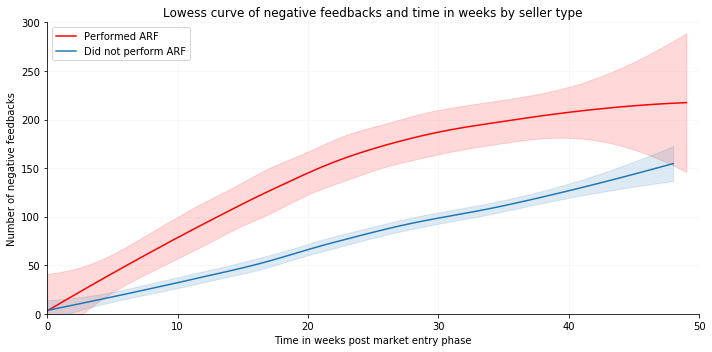

In [6]:
fig, ax = plt.subplots(figsize =  [10, 5])
ax.grid(True, which="both", ls="-", alpha = .1)

s = [df['arf'], ~df['arf']]
c = ['red', '#1f77b4']
l = ['Performed ARF', 'Did not perform ARF']

for selection, color, label in zip(s, c, l):
    # preprocess data
    d_ = df[selection].sort_values('w').copy()
    y = d_['neg_count_min'].to_numpy()
    x = d_['w'] - 2
    x_ = x.unique()

    # fit and predict lowess curve
    l = loess(x.to_numpy(), y, frac=0.1)
    l.fit()
    pred  = l.predict(x_, stderror=True)
    val   = pred.values
    conf  = pred.confidence()
    lower = conf.lower
    upper = conf.upper

    # plot lowess curve with 95% confidence
    ax.plot(x_, val, color=color, label = label)
    ax.fill_between(x_, lower, upper, alpha=.15, color=color)

ax.set_xlim(0, 50)
ax.set_ylim(0, 300)

# set titles and axes labels
ax.set_title('Lowess curve of negative feedbacks and time in weeks by seller type')
ax.set_ylabel('Number of negative feedbacks')
ax.set_xlabel('Time in weeks post market entry phase')
ax.legend(loc = 'upper left')

# show plot
plt.tight_layout()
plt.show()

In [7]:
%%R -o model1_fit

# Create empty list for results
model1 <- list()

# Baseline Model
model1 <- append(model1, 
                 list(a = glm(c_neg_count_w_shift ~ 1,
                              data, 
                              family = poisson)))

# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted) 
# empty
model1 <- append(model1, 
                 list(b = glmer(c_neg_count_w_shift ~ 1
                                + (1 | vendor),
                                data, 
                                family = poisson)))

# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted) 
# Including control variables
model1 <- append(model1, 
                 list(c = glmer(c_neg_count_w_shift ~ 1
                                + (1 | vendor) + (1 | w),
                                data, 
                                family = poisson)))

icc1 <- getICCs(m = model1$c)

# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted) 
# without interaction with bobyqa optimization
Optimizer <- glmerControl(optimizer = "bobyqa",
                          optCtrl = list(maxfun=2e5))

model1 <- append(model1, 
                 list(d = glmer(c_neg_count_w_shift ~ 
                                + bc_pos_count_w.m
                                + bc_pos_count_w.dev
                                + bc_item_count_w.m
                                + bc_item_count_w.dev
                                + bc_int_shipment_count_w.m
                                + bc_int_shipment_count_w.dev
                                + me_ + me_2 
                                + w_ + w_2 
                                + (1 | vendor) + (1 | w),
                                data, 
                                family = poisson,
                                control = Optimizer)))


# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted)
# cross-level-interaction of ARF and Negative Feedbacks with 
# bobyqa optimization
model1 <- append(model1, 
                 list(e = glmer(c_neg_count_w_shift ~ arf
                                + bc_pos_count_w.m
                                + bc_pos_count_w.dev
                                + bc_item_count_w.m
                                + bc_item_count_w.dev
                                + bc_int_shipment_count_w.m
                                + bc_int_shipment_count_w.dev
                                + me_ + me_2 
                                + w_ + w_2 
                                + (1 | vendor) + (1 | w),
                                data, 
                                family = poisson,
                                control = Optimizer)))

model1_fit<- round(data.frame(t(anova(model1$b, model1$c, model1$d, model1$e))), 3)

In [8]:
%%R -o model1_res

# clean results
model1_res <- round(data.frame(summary(model1$e)[10]),3)
colnames(model1_res) <- c("B", 'se', 'z', 'p')

# generate odds ratios
odds = data.frame(tidy(model1$e,conf.int=TRUE,exponentiate=TRUE,effects="fixed")) %>%
    select(c("estimate", "conf.low", "conf.high")) %>%
    mutate_all(funs(round(.,3)))
colnames(odds) <- c("or", "ci_low", "ci_high")
model1_res <- cbind(model1_res, odds)

In [9]:
model1_fit

,model1.b,model1.c,model1.d,model1.e
npar,2.000,3.000,13.000,14.000
AIC,167577.677,148011.492,147344.941,147337.250
BIC,167593.744,148035.592,147449.376,147449.719
logLik,-83786.838,-74002.746,-73659.470,-73654.625
deviance,167573.677,148005.492,147318.941,147309.250
Chisq,NaN,19568.185,686.551,9.691
Df,NaN,1.000,10.000,1.000
Pr(>Chisq),NaN,0.000,0.000,0.002


### ARM

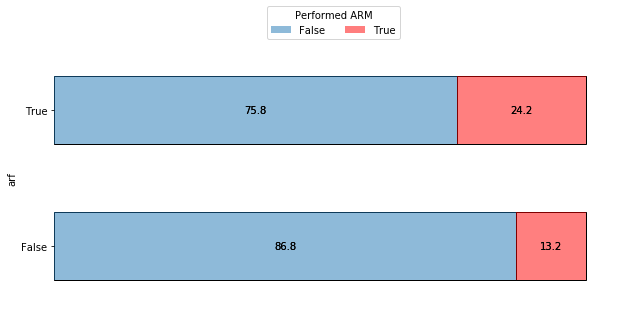

In [10]:
ct = pd.crosstab(df['arf'], df['arm_maxw_shift'], normalize = 'index')

fig, ax = plt.subplots(figsize =  [10, 5])
ax.invert_yaxis()

ct.plot.barh(stacked = True, 
             ax = ax, 
             edgecolor = 'black',
             color = ['none', 'none'])
ct.plot.barh(stacked = True, 
             ax = ax,
             rot = 0, 
             color = ['#1f77b4', 'red'],
             alpha = .5) 

# make legends for right panel 
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), 
          loc='upper center', bbox_to_anchor=(0.5, 1.15), 
          ncol = 2, title = 'Performed ARM')

# Value labels
patches = ax.patches
for rect in patches:
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., round(width*100, 1), ha='center', va='center')

ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks([])
plt.show()

In [11]:
%%R -o model2_fit

# Create empty list for results
model2 <- list()

# Baseline Model
model2 <- append(model2, 
                 list(a = glm(arm_maxw_shift ~ 1,
                              data, 
                              family = binomial)))

# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted) 
# empty
model2 <- append(model2, 
                 list(b = glmer(arm_maxw_shift ~ 1
                                + (1 | vendor),
                                data, 
                                family = binomial)))

# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted) 
# Including control variables
model2 <- append(model2, 
                 list(c = glmer(arm_maxw_shift ~ 1
                                + (1 | vendor) + (1 | w),
                                data, 
                                family = binomial)))

icc2 <- getICCs(model2$c, 'binomial')

# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted) 
# without interaction with bobyqa optimization
Optimizer <- glmerControl(optimizer = "bobyqa",
                          optCtrl = list(maxfun=2e5))

model2 <- append(model2, 
                 list(d = glmer(arm_maxw_shift ~ 
                                + bc_pos_count_w.m
                                + bc_pos_count_w.dev
                                + bc_item_count_w.m
                                + bc_item_count_w.dev
                                + bc_int_shipment_count_w.m
                                + bc_int_shipment_count_w.dev
                                + me_ + me_2 
                                + w_ + w_2 
                                + (1 | vendor) + (1 | w),
                                data, 
                                family = binomial,
                                control = Optimizer)))


# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted)
# cross-level-interaction of ARF and Negative Feedbacks with 
# bobyqa optimization
model2 <- append(model2, 
                 list(e = glmer(arm_maxw_shift ~ arf
                                + bc_neg_count_w.m
                                + bc_neg_count_w.dev
                                + bc_neg_count_w.m:arf
                                + bc_neg_count_w.dev:arf
                                + bc_pos_count_w.m
                                + bc_pos_count_w.dev
                                + bc_item_count_w.m
                                + bc_item_count_w.dev
                                + bc_int_shipment_count_w.m
                                + bc_int_shipment_count_w.dev
                                + me_ + me_2 
                                + w_ + w_2 
                                + (1 | vendor) + (1 | w),
                                data, 
                                family = binomial, 
                                control = Optimizer)))

model2_fit<- round(data.frame(t(anova(model2$b, model2$c, model2$d, model2$e))), 3)

In [12]:
%%R -o model2_res

# clean results
model2_res <- round(data.frame(summary(model2$e)[10]),3)
colnames(model2_res) <- c("B", 'se', 'z', 'p')

# generate odds ratios
odds = data.frame(tidy(model2$e,conf.int=TRUE,exponentiate=TRUE,effects="fixed")) %>%
    select(c("estimate", "conf.low", "conf.high")) %>%
    mutate_all(funs(round(.,3)))
colnames(odds) <- c("or", "ci_low", "ci_high")
model2_res <- cbind(model2_res, odds)

In [13]:
model2_fit

,model2.b,model2.c,model2.d,model2.e
npar,2.000,3.000,13.000,18.000
AIC,10767.511,10644.645,6441.765,6397.763
BIC,10783.578,10668.746,6546.200,6542.366
logLik,-5381.755,-5319.323,-3207.882,-3180.882
deviance,10763.511,10638.645,6415.765,6361.763
Chisq,NaN,124.865,4222.881,54.001
Df,NaN,1.000,10.000,5.000
Pr(>Chisq),NaN,0.000,0.000,0.000


In [14]:
def sig_stars(x):
    if x < .001: 
        return "***"
    if x < .01: 
        return "**"
    if x < .05:
        return "*"
    if x < .1: 
        return "+"
    else: 
        return ""

def parse_model(data, i):
    ci_fmt = lambda x: f"({str(round(x['ci_low'], 3)).ljust(5, '0')}; {str(round(x['ci_high'], 3)).ljust(5, '0')})"
    m = data\
        .assign(star = lambda x: x['p'].apply(sig_stars))\
        .assign(B_ = lambda x: x["B"].round(3).astype(str) + x["star"],
                _or  = lambda x: x["or"].round(3).astype(str) + x["star"],
                ci = lambda row: row.agg(ci_fmt, axis=1))\
        [['_or', 'ci']]
    
    # Add MultiIndex Columns
    arrays = ([f"model{i + 1}"] * len(m.columns), m.columns)
    m.columns = pd.MultiIndex.from_arrays(arrays)
    
    return m

order = [0, 1] + [12, 13, 14, 15] + [ 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
df = pd.concat([
            parse_model(m, i) for i, m in enumerate([model1_res, model2_res])
        ], axis = 1)\
        .fillna('')
df = df.reindex([df.index.to_list()[i] for i in order])\
    .stack()

df.to_csv(os.path.join(MAINDIR, 'tabs', 'coef_table.csv'))

In [15]:
df.reset_index().drop('level_1', axis = 1).to_latex(os.path.join(MAINDIR, 'tabs', 'coef_table.tex'), index = False)

In [16]:
df

model1            model2
(Intercept)                 _or            0.631**          0.002***
                            ci      (0.470; 0.848)    (0.001; 0.002)
arf                         _or            1.606**           2.262**
                            ci      (1.194; 2.160)    (1.336; 3.829)
bc_neg_count_w.m            _or                             2.481***
                            ci                        (1.824; 3.376)
bc_neg_count_w.dev          _or                                1.058
                            ci                        (0.968; 1.156)
arf:bc_neg_count_w.m        _or                                0.821
                            ci                        (0.401; 1.681)
arf:bc_neg_count_w.dev      _or                                1.107
                            ci                        (0.917; 1.336)
bc_pos_count_w.m            _or              1.186         34.283***
                            ci      (0.954; 1.475)  (22.008; 53.404)
bc_pos_count_w.dev          _or           1.043***         95.748***
                            ci      (1.032; 1.054)  (74.022; 123.85)
bc_item_count_w.m           _or           1.847***          9.541***
                            ci      (1.479; 2.306)   (6.281; 14.492)
bc_item_count_w.dev         _or           0.848***          1.705***
                            ci      (0.826; 0.869)    (1.308; 2.223)
bc_int_shipment_count_w.m   _or           1.498***             0.885
                            ci      (1.319; 1.702)    (0.723; 1.083)
bc_int_shipment_count_w.dev _or           1.137***             1.047
                            ci      (1.091; 1.185)    (0.724; 1.512)
me_                         _or             1.293+             1.366
                            ci      (0.998; 1.675)    (0.873; 2.138)
me_2                        _or           0.638***             0.859
                            ci      (0.503; 0.809)    (0.565; 1.306)
w_                          _or          54.618***           0.567**
                            ci   (18.842; 158.322)    (0.397; 0.809)
w_2                         _or           0.006***          1.936***
                            ci      (0.002; 0.018)    (1.370; 2.738)